# Análise Completa da Camada RAW - Bronze Layer
## Microsoft Security Incident Prediction Dataset

---

### Objetivo
Análise exploratória completa da camada RAW (Bronze) incluindo:
- ✓ Data Validation e Integridade
- ✓ Data Profiling e Categorização
- ✓ Análise de Qualidade
- ✓ Visualização de Outliers
- ✓ Detecção de Anomalias

**IMPORTANTE:** Este notebook contém APENAS análises apropriadas para camada RAW.

## 1. Importações e Configurações

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
import os
import hashlib
import json
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

# Configurações para melhor visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Cores para visualizações
colors_target = {
    'TruePositive':'#2ecc71',
    'FalsePositive': '#e74c3c',
    'BenignPositive': '#3498db'
}

print(' Todas as bibliotecas importadas com sucesso')

 Todas as bibliotecas importadas com sucesso


In [21]:

from pathlib import Path

def read_csv_robust(path, chunksize=200000, encoding='utf8', sep=','):
    """
    Tenta carregar CSV com pandas. Se falhar, retorna um iterator de chunks.
    
    Args:
        path: Caminho do arquivo CSV
        chunksize: Tamanho dos chunks para leitura iterativa
        encoding: Encoding do arquivo
        sep: Separador do CSV
    
    Returns:
        DataFrame ou iterator de chunks
    """
    try:
        df = pd.read_csv(path, sep=sep, encoding=encoding, low_memory=True)
        return df
    except Exception as e:
        print(f' Aviso: não foi possível carregar o CSV completo: {type(e).__name__} - {e}')
        print(f'Retornando um iterator de chunks. Use: for chunk in df: ...')
        iterator = pd.read_csv(
            path, 
            sep=sep, 
            encoding=encoding, 
            chunksize=chunksize, 
            low_memory=True, 
            iterator=True
        )
        return iterator

## 2. Carregamento e Validação de Integridade

In [22]:
# O arquivo train.csv está no mesmo diretório do notebook
# Usar caminho relativo simples
data_path = 'train.csv'
# Se não encontrar no diretório atual, tenta caminhos alternativos
if not os.path.exists(data_path):
    # Tenta no diretório raw
    alt_path = os.path.join('raw', 'train.csv')
    if os.path.exists(alt_path):
        data_path = alt_path
    else:
        # Tenta no diretório data_layer/raw
        alt_path2 = os.path.join('data_layer', 'raw', 'train.csv')
        if os.path.exists(alt_path2):
            data_path = alt_path2

# Definir base_path para uso posterior (metadados)
base_path = os.path.dirname(os.path.abspath(data_path)) if os.path.dirname(os.path.abspath(data_path)) else '.'

print('Verificando integridade do arquivo...\n')

if os.path.exists(data_path):
    print(f' Arquivo encontrado: {os.path.abspath(data_path)}\n')
    
    # Calcular checksum MD5
    md5_hash = hashlib.md5()
    with open(data_path, 'rb') as f:
        for chunk in iter(lambda: f.read(4096), b''):
            md5_hash.update(chunk)
    checksum = md5_hash.hexdigest()
    
    # Informações do arquivo
    file_size = os.path.getsize(data_path) / (1024**2)
    mod_time = datetime.fromtimestamp(os.path.getmtime(data_path))
    
    print(f' Tamanho do arquivo: {file_size:.2f} MB')
    print(f' Data de modificação: {mod_time}')
    print(f' Checksum MD5: {checksum}\n')
else:
    print(f' Arquivo NÃO encontrado: {data_path}')
    raise FileNotFoundError(f'Arquivo não encontrado: {data_path}')

Verificando integridade do arquivo...

 Arquivo encontrado: C:\Users\fabio\OneDrive\Área de Trabalho\SBD2\data_layer\raw\train.csv

 Tamanho do arquivo: 2313.05 MB
 Data de modificação: 2025-10-10 20:28:00.873615
 Checksum MD5: 115c2d188e80826d9fbdb9c8784afa22



In [23]:
# Carregamento do dataset
print('Carregando dataset...\n')

df = read_csv_robust(
    data_path,
    sep=',',
    encoding='utf8'
)

# Verificar se retornou um iterator ou DataFrame
if hasattr(df, '__iter__') and not isinstance(df, pd.DataFrame):
    print(' Dataset muito grande, carregando em chunks...')
    # Carregar o primeiro chunk para análise
    df = next(df)
    print('ℹ Usando apenas o primeiro chunk para análise\n')

# Converter colunas de tempo para datetime se existirem
for time_col in ['Timestamp', 'Date', 'EventTime']:
    if time_col in df.columns:
        try:
            df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
        except Exception:
            pass

print(f' Dataset carregado com sucesso!\n')
print(f'Registros: {len(df):,}')
print(f' Colunas: {len(df.columns)}')
print(f' Memória total: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB')

Carregando dataset...

 Dataset carregado com sucesso!

Registros: 9,516,837
 Colunas: 45
 Memória total: 7300.76 MB


## 3. Data Validation - Estrutura e Tipos

In [24]:
print('\n=== PRIMEIRAS 5 LINHAS - DADOS BRUTOS ===\n')
df.head()


=== PRIMEIRAS 5 LINHAS - DADOS BRUTOS ===



,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,ActionGrouped,ActionGranular,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,EmailClusterId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,ThreatFamily,FileName,FolderPath,ResourceIdName,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
0,180388628218,0,612,123247,2024-06-04 06:05:15+00:00,7,6,InitialAccess,NaN,TruePositive,NaN,NaN,Ip,Related,98799,138268,27,160396,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,31,6,3
1,455266534868,88,326,210035,2024-06-14 03:01:25+00:00,58,43,Exfiltration,NaN,FalsePositive,NaN,NaN,User,Impacted,98799,138268,360606,160396,22406,23032,22795,24887,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
2,1056561957389,809,58352,712507,2024-06-13 04:52:55+00:00,423,298,InitialAccess,T1189,FalsePositive,NaN,NaN,Url,Related,98799,138268,360606,68652,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
3,1279900258736,92,32992,774301,2024-06-10 16:39:36+00:00,2,2,CommandAndControl,NaN,BenignPositive,NaN,NaN,Url,Related,98799,138268,360606,13,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
4,214748368522,148,4359,188041,2024-06-15 01:08:07+00:00,9,74,Execution,NaN,TruePositive,NaN,NaN,User,Impacted,98799,138268,360606,160396,449,592,440,479,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630


In [25]:
print('\n=== INFORMAÇÕES ESTRUTURAIS ===\n')
df.info()


=== INFORMAÇÕES ESTRUTURAIS ===

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9516837 entries, 0 to 9516836
Data columns (total 45 columns):
 #   Column              Dtype              
---  ------              -----              
 0   Id                  int64              
 1   OrgId               int64              
 2   IncidentId          int64              
 3   AlertId             int64              
 4   Timestamp           datetime64[ns, UTC]
 5   DetectorId          int64              
 6   AlertTitle          int64              
 7   Category            object             
 8   MitreTechniques     object             
 9   IncidentGrade       object             
 10  ActionGrouped       object             
 11  ActionGranular      object             
 12  EntityType          object             
 13  EvidenceRole        object             
 14  DeviceId            int64              
 15  Sha256              int64              
 16  IpAddress           int64             

In [26]:
print('\n=== ESTATÍSTICAS DESCRITIVAS (Colunas Numéricas) ===\n')
df.describe()


=== ESTATÍSTICAS DESCRITIVAS (Colunas Numéricas) ===



,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,EmailClusterId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City
count,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.681200e+04,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06
mean,8.425494e+11,1.815800e+02,7.066349e+04,4.065188e+05,1.106724e+02,2.947315e+03,9.566476e+04,1.287191e+05,2.857506e+05,1.503317e+05,3.524466e+05,4.643773e+05,3.409622e+05,3.569664e+05,1.432298e+05,4.800467e+05,3.242503e+09,1.628170e+03,6.347345e+02,8.595601e+02,2.200910e+03,3.342790e+03,8.807955e+02,2.622621e+05,1.076172e+05,3.583477e+03,4.898537e+00,6.465558e+01,2.236742e+02,1.351488e+03,9.936183e+03
std,4.962499e+11,3.867784e+02,1.208369e+05,4.592827e+05,4.351038e+02,1.146150e+04,1.635288e+04,3.399208e+04,1.412240e+05,3.750795e+04,1.664965e+05,2.902275e+05,1.599377e+05,1.744466e+05,3.607056e+04,1.417584e+05,1.034468e+09,6.675012e+01,1.258111e+01,1.886303e+01,3.315528e+02,5.103381e+02,1.291083e+01,8.152956e+04,3.220835e+04,9.020262e+01,7.035099e-01,9.314929e+00,6.279729e+01,3.509808e+02,2.606812e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.927080e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.123169e+11,1.000000e+01,5.040000e+02,2.324200e+04,2.000000e+00,2.000000e+00,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,4.413770e+05,9.258300e+04,4.258630e+05,4.532970e+05,1.530850e+05,5.296440e+05,2.762798e+09,1.631000e+03,6.350000e+02,8.600000e+02,2.251000e+03,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
50%,8.418136e+11,4.500000e+01,1.033600e+04,2.166520e+05,9.000000e+00,1.100000e+01,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,4.413770e+05,6.739340e+05,4.258630e+05,4.532970e+05,1.530850e+05,5.296440e+05,3.504264e+09,1.631000e+03,6.350000e+02,8.600000e+02,2.251000e+03,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
75%,1.271310e+12,1.710000e+02,8.432900e+04,6.715770e+05,4.500000e+01,1.800000e+02,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,4.413770e+05,6.739340e+05,4.258630e+05,4.532970e+05,1.530850e+05,5.296440e+05,4.107006e+09,1.631000e+03,6.350000e+02,8.600000e+02,2.251000e+03,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
max,1.709397e+12,6.147000e+03,5.997060e+05,1.721456e+06,9.522000e+03,1.131740e+05,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,4.413770e+05,6.739340e+05,4.258630e+05,4.532970e+05,1.530850e+05,5.296440e+05,4.294967e+09,1.631000e+03,6.350000e+02,8.600000e+02,2.251000e+03,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04


## 4. Categorização de Colunas (Data Profiling)

In [27]:
# Categorizar colunas automaticamente
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

print('\n=== CATEGORIZAÇÃO DE COLUNAS ===\n')
print(f'Colunas Categóricas ({len(categorical_cols)}): ')
for col in categorical_cols:
    print(f'  • {col}')

print(f'\nColunas Numéricas ({len(numerical_cols)}): ')
for col in numerical_cols:
    print(f'  • {col}')


=== CATEGORIZAÇÃO DE COLUNAS ===

Colunas Categóricas (13): 
  • Category
  • MitreTechniques
  • IncidentGrade
  • ActionGrouped
  • ActionGranular
  • EntityType
  • EvidenceRole
  • ThreatFamily
  • ResourceType
  • Roles
  • AntispamDirection
  • SuspicionLevel
  • LastVerdict

Colunas Numéricas (31): 
  • Id
  • OrgId
  • IncidentId
  • AlertId
  • DetectorId
  • AlertTitle
  • DeviceId
  • Sha256
  • IpAddress
  • Url
  • AccountSid
  • AccountUpn
  • AccountObjectId
  • AccountName
  • DeviceName
  • NetworkMessageId
  • EmailClusterId
  • RegistryKey
  • RegistryValueName
  • RegistryValueData
  • ApplicationId
  • ApplicationName
  • OAuthApplicationId
  • FileName
  • FolderPath
  • ResourceIdName
  • OSFamily
  • OSVersion
  • CountryCode
  • State
  • City


## 5. Análise de Valores Únicos (Data Profiling)

In [28]:
print('\n=== VALORES ÚNICOS - COLUNAS CATEGÓRICAS ===\n')

unique_summary = pd.DataFrame({
    'Coluna': categorical_cols,
    'Valores Únicos': [df[col].nunique() for col in categorical_cols],
    'Exemplo': [str(df[col].dropna().unique()[:3]) for col in categorical_cols]
}).sort_values('Valores Únicos', ascending=False)

print(unique_summary.to_string(index=False))


=== VALORES ÚNICOS - COLUNAS CATEGÓRICAS ===

           Coluna  Valores Únicos                                                                                        Exemplo
     ThreatFamily            1745                                                        ['CymRan' 'CVE-2017-11882' 'Masqshell']
  MitreTechniques            1193                                                            ['T1189' 'T1078;T1078.004' 'T1566']
       EntityType              33                                                                            ['Ip' 'User' 'Url']
     ResourceType              25                                      ['Virtual Machine' 'API Management Service' 'Networking']
         Category              20                                           ['InitialAccess' 'Exfiltration' 'CommandAndControl']
   ActionGranular              16 ['account password changed' 'update stsrefreshtokenvalidfrom timestamp.'\n 'account disabled']
            Roles              10                 

In [29]:
main_categorical = ['Category', 'EntityType', 'EvidenceRole', 'OSFamily']
main_categorical = [col for col in main_categorical if col in df.columns]

print('\n=== EXEMPLOS DE VALORES ÚNICOS - PRINCIPAIS CATEGORIAS ===\n')
for col in main_categorical:
    unique_vals = df[col].dropna().unique()
    print(f'{col}: {list(unique_vals)}\n')


=== EXEMPLOS DE VALORES ÚNICOS - PRINCIPAIS CATEGORIAS ===

Category: ['InitialAccess', 'Exfiltration', 'CommandAndControl', 'Execution', 'SuspiciousActivity', 'Impact', 'Collection', 'CredentialAccess', 'Persistence', 'Discovery', 'Malware', 'DefenseEvasion', 'Exploit', 'PrivilegeEscalation', 'LateralMovement', 'Ransomware', 'UnwantedSoftware', 'CredentialStealing', 'WebExploit', 'Weaponization']

EntityType: ['Ip', 'User', 'Url', 'MailMessage', 'Process', 'Machine', 'CloudApplication', 'AzureResource', 'File', 'Mailbox', 'CloudLogonRequest', 'MailCluster', 'Malware', 'CloudLogonSession', 'OAuthApplication', 'RegistryValue', 'SecurityGroup', 'RegistryKey', 'GenericEntity', 'ActiveDirectoryDomain', 'BlobContainer', 'Blob', 'MailboxConfiguration', 'IoTDevice', 'AmazonResource', 'Nic', 'Container', 'GoogleCloudResource', 'KubernetesCluster', 'ContainerImage', 'KubernetesNamespace', 'KubernetesPod', 'ContainerRegistry']

EvidenceRole: ['Related', 'Impacted']

OSFamily: [np.int64(5), np.i

## 6. Análise de Valores Ausentes (Quality Check)

In [30]:
print('\n=== ANÁLISE DE VALORES AUSENTES ===\n')

missing_data = pd.DataFrame({
    'Coluna': df.columns,
    'Faltantes': df.isnull().sum(),
    'Percentual': (df.isnull().sum() / len(df) * 100).round(2)
}).sort_values('Percentual', ascending=False)

print(missing_data.to_string(index=False))

print(f'\nResumo:')
print(f'Total de colunas: {len(df.columns)}')
print(f'Colunas SEM valores ausentes: {(missing_data["Percentual"] == 0).sum()}')
print(f'Colunas COM valores ausentes: {(missing_data["Percentual"] > 0).sum()}')
print(f'Colunas COM >95% ausentes: {(missing_data["Percentual"] > 95).sum()}')
print(f'Colunas COM 50-95% ausentes: {((missing_data["Percentual"] >= 50) & (missing_data["Percentual"] <= 95)).sum()}')
print(f'Colunas COM 0-50% ausentes: {((missing_data["Percentual"] > 0) & (missing_data["Percentual"] < 50)).sum()}')


=== ANÁLISE DE VALORES AUSENTES ===

            Coluna  Faltantes  Percentual
      ResourceType    9509762       99.93
     ActionGrouped    9460773       99.41
    ActionGranular    9460773       99.41
      ThreatFamily    9441956       99.21
    EmailClusterId    9420025       98.98
 AntispamDirection    9339535       98.14
             Roles    9298686       97.71
    SuspicionLevel    8072708       84.83
       LastVerdict    7282572       76.52
   MitreTechniques    5468386       57.46
     IncidentGrade      51340        0.54
         Timestamp          0        0.00
                Id          0        0.00
        EntityType          0        0.00
        DetectorId          0        0.00
        AlertTitle          0        0.00
          Category          0        0.00
             OrgId          0        0.00
        IncidentId          0        0.00
           AlertId          0        0.00
      EvidenceRole          0        0.00
   AccountObjectId          0        0

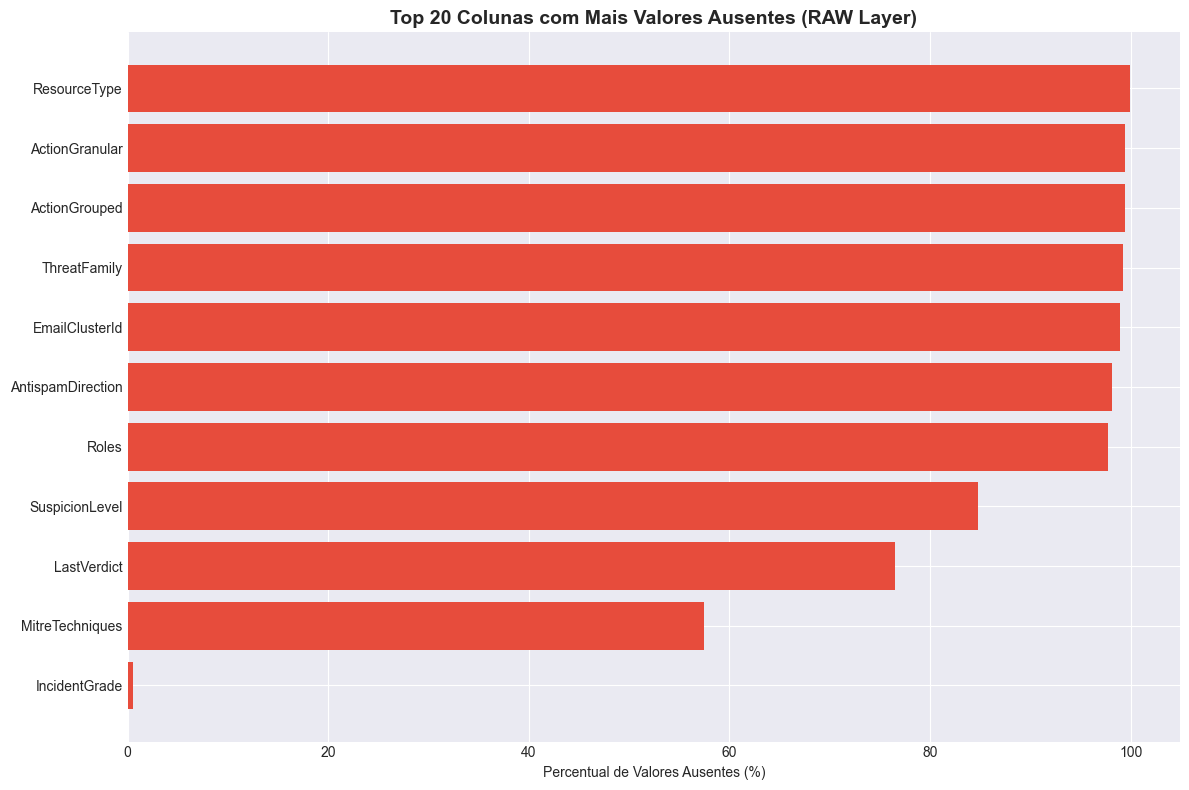

In [31]:
# Visualizar valores ausentes
fig, ax = plt.subplots(figsize=(12, 8))
missing_pct = missing_data[missing_data['Percentual'] > 0].sort_values('Percentual')

if len(missing_pct) > 0:
    ax.barh(missing_pct['Coluna'].tail(20), missing_pct['Percentual'].tail(20), color='#e74c3c')
    ax.set_xlabel('Percentual de Valores Ausentes (%)')
    ax.set_title('Top 20 Colunas com Mais Valores Ausentes (RAW Layer)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print(' Nenhum valor ausente detectado no dataset')

## 7. Distribuição da Variável Target

In [32]:
if 'IncidentGrade' in df.columns:
    print('\n=== DISTRIBUIÇÃO - VARIÁVEL TARGET (IncidentGrade) ===\n')
    
    target_dist = df['IncidentGrade'].value_counts()
    target_pct = df['IncidentGrade'].value_counts(normalize=True) * 100
    
    target_summary = pd.DataFrame({
        'Classe': target_dist.index,
        'Contagem': target_dist.values,
        'Percentual': target_pct.values.round(2)
    })
    
    print(target_summary.to_string(index=False))
    
    max_pct = target_pct.max()
    min_pct = target_pct.min()
    ratio = max_pct / min_pct
    
    print(f'\nAnálise de Desbalanceamento:')
    print(f' Proporção maior/menor: {ratio:.2f}x')
    if ratio > 3:
        print(f' AVISO: Desbalanceamento significativo detectado')
    else:
        print(f' Desbalanceamento moderado')
else:
    print('ℹ Coluna "IncidentGrade" não encontrada no dataset')


=== DISTRIBUIÇÃO - VARIÁVEL TARGET (IncidentGrade) ===

        Classe  Contagem  Percentual
BenignPositive   4110817       43.43
  TruePositive   3322713       35.10
 FalsePositive   2031967       21.47

Análise de Desbalanceamento:
 Proporção maior/menor: 2.02x
 Desbalanceamento moderado


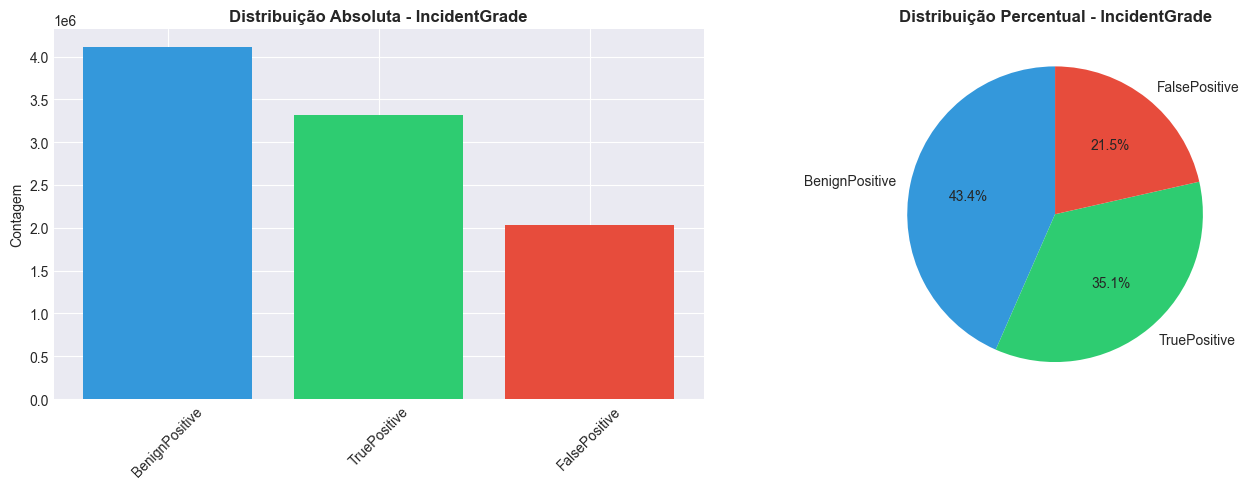

In [33]:
if 'IncidentGrade' in df.columns:
    target_dist = df['IncidentGrade'].value_counts()
    target_pct = df['IncidentGrade'].value_counts(normalize=True) * 100
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    colors_list = [colors_target.get(val, '#95a5a6') for val in target_dist.index]
    
    axes[0].bar(target_dist.index, target_dist.values, color=colors_list)
    axes[0].set_ylabel('Contagem')
    axes[0].set_title('Distribuição Absoluta - IncidentGrade', fontweight='bold')
    axes[0].tick_params(axis='x', rotation=45)
    
    axes[1].pie(target_pct.values, labels=target_pct.index, autopct='%1.1f%%', colors=colors_list, startangle=90)
    axes[1].set_title('Distribuição Percentual - IncidentGrade', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

## 8. Detecção e Visualização de Outliers

In [34]:
# Função IQR para detecção de outliers
def detect_outliers_iqr(data, column):
    """
    Detecta outliers usando o método IQR (Interquartile Range)
    
    Args:
        data: DataFrame
        column: Nome da coluna para análise
    
    Returns:
        Series booleana indicando outliers
    """
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (data[column] < lower_bound) | (data[column] > upper_bound)

# Detectar outliers para cada coluna numérica
print('\n=== DETECÇÃO DE OUTLIERS (IQR Method) ===\n')
outliers_summary = []

for col in numerical_cols:
    outlier_mask = detect_outliers_iqr(df, col)
    n_outliers = outlier_mask.sum()
    pct_outliers = (n_outliers / len(df)) * 100
    
    if n_outliers > 0:
        outliers_summary.append({
            'Coluna': col,
            'Total Outliers': n_outliers,
            'Percentual': pct_outliers.round(2),
            'Min': df[col].min(),
            'Max': df[col].max()
        })

outliers_df = pd.DataFrame(outliers_summary).sort_values('Total Outliers', ascending=False)

if len(outliers_df) > 0:
    print(outliers_df.to_string(index=False))
else:
    print('Nenhum outlier detectado com método IQR')


=== DETECÇÃO DE OUTLIERS (IQR Method) ===

            Coluna  Total Outliers  Percentual      Min          Max
       AccountName         2366577       24.87      0.0     453297.0
        AccountSid         2254382       23.69      0.0     441377.0
   AccountObjectId         2230542       23.44      0.0     425863.0
         IpAddress         2177673       22.88      0.0     360606.0
        AlertTitle         1886784       19.83      0.0     113174.0
        DetectorId         1396226       14.67      0.0       9522.0
  NetworkMessageId         1158839       12.18      0.0     529644.0
             OrgId         1156193       12.15      0.0       6147.0
        IncidentId         1111667       11.68      0.0     599706.0
          FileName         1028947       10.81      0.0     289573.0
        FolderPath          875633        9.20      0.0     117668.0
       CountryCode          749925        7.88      0.0        242.0
            Sha256          732773        7.70      0.0    

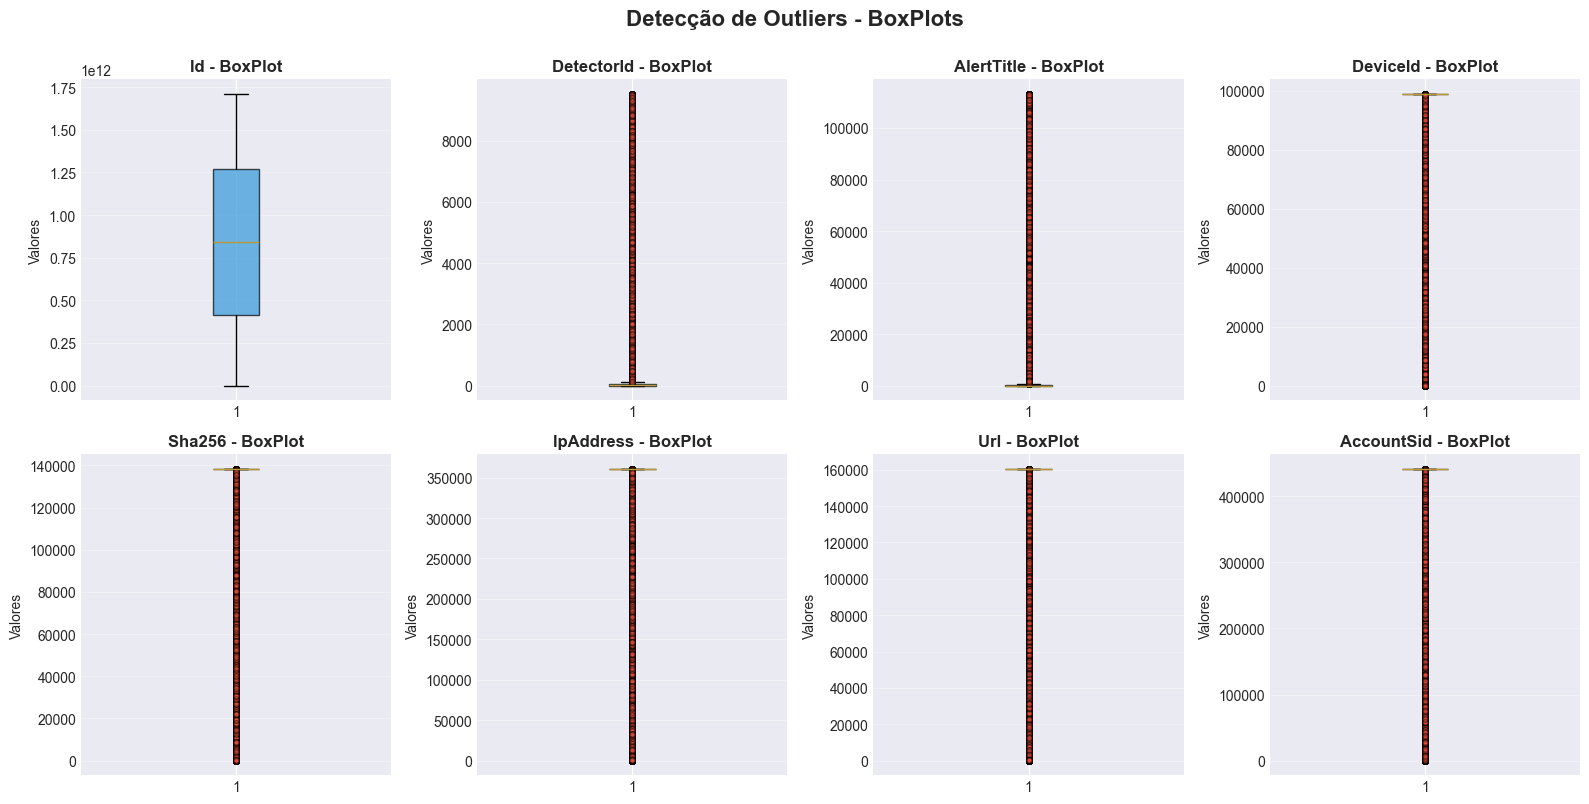

In [35]:
# BoxPlots para detectar outliers visualmente
main_numeric_cols = [col for col in numerical_cols if col not in ['OrgId', 'IncidentId', 'AlertId']][:8]

if main_numeric_cols:
    n_cols = len(main_numeric_cols)
    n_rows = (n_cols + 3) // 4
    
    fig, axes = plt.subplots(n_rows, 4, figsize=(16, 4 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    for idx, col in enumerate(main_numeric_cols):
        ax = axes[idx]
        bp = ax.boxplot(df[col].dropna(), vert=True, patch_artist=True)
        
        for patch in bp['boxes']:
            patch.set_facecolor('#3498db')
            patch.set_alpha(0.7)
        
        for flier in bp['fliers']:
            flier.set(marker='o', markerfacecolor='#e74c3c', markersize=4, alpha=0.5)
        
        ax.set_ylabel('Valores')
        ax.set_title(f'{col} - BoxPlot', fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
    
    # Ocultar axes extras
    for idx in range(len(main_numeric_cols), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Detecção de Outliers - BoxPlots', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()
else:
    print('ℹ Nenhuma coluna numérica disponível para análise de outliers')

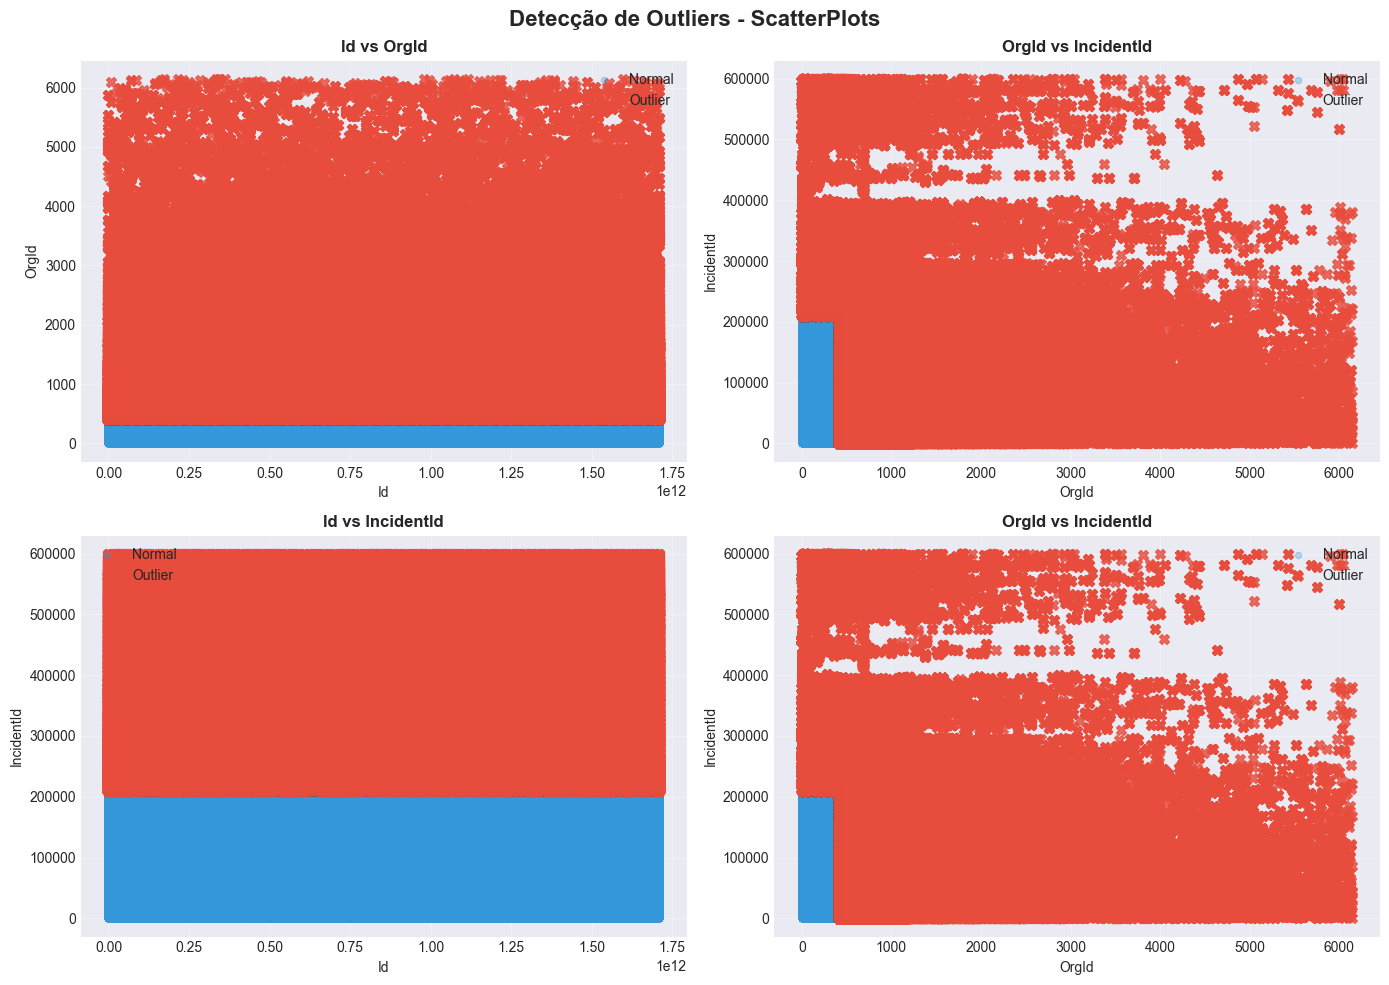

In [36]:
# ScatterPlots mostrando outliers destacados
if len(numerical_cols) >= 2:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    # Criar pares de colunas para análise
    pairs = []
    if len(numerical_cols) >= 3:
        pairs = [
            (numerical_cols[0], numerical_cols[1]),
            (numerical_cols[1], numerical_cols[2]),
            (numerical_cols[0], numerical_cols[2]),
            (numerical_cols[1], numerical_cols[2])
        ]
    else:
        pairs = [(numerical_cols[0], numerical_cols[1])] * 4
    
    for idx, (col1, col2) in enumerate(pairs):
        if col1 != col2:
            ax = axes[idx]
            
            out1 = detect_outliers_iqr(df, col1)
            out2 = detect_outliers_iqr(df, col2)
            outlier_mask = out1 | out2
            
            # Plot normal points
            ax.scatter(df.loc[~outlier_mask, col1], df.loc[~outlier_mask, col2], 
                      c='#3498db', alpha=0.3, s=20, label='Normal')
            
            # Plot outliers
            if outlier_mask.sum() > 0:
                ax.scatter(df.loc[outlier_mask, col1], df.loc[outlier_mask, col2], 
                          c='#e74c3c', alpha=0.8, s=50, marker='X', label='Outlier')
            
            ax.set_xlabel(col1)
            ax.set_ylabel(col2)
            ax.set_title(f'{col1} vs {col2}', fontweight='bold')
            ax.legend()
            ax.grid(alpha=0.3)
    
    plt.suptitle('Detecção de Outliers - ScatterPlots', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print('ℹ Não há colunas numéricas suficientes para análise de correlação')

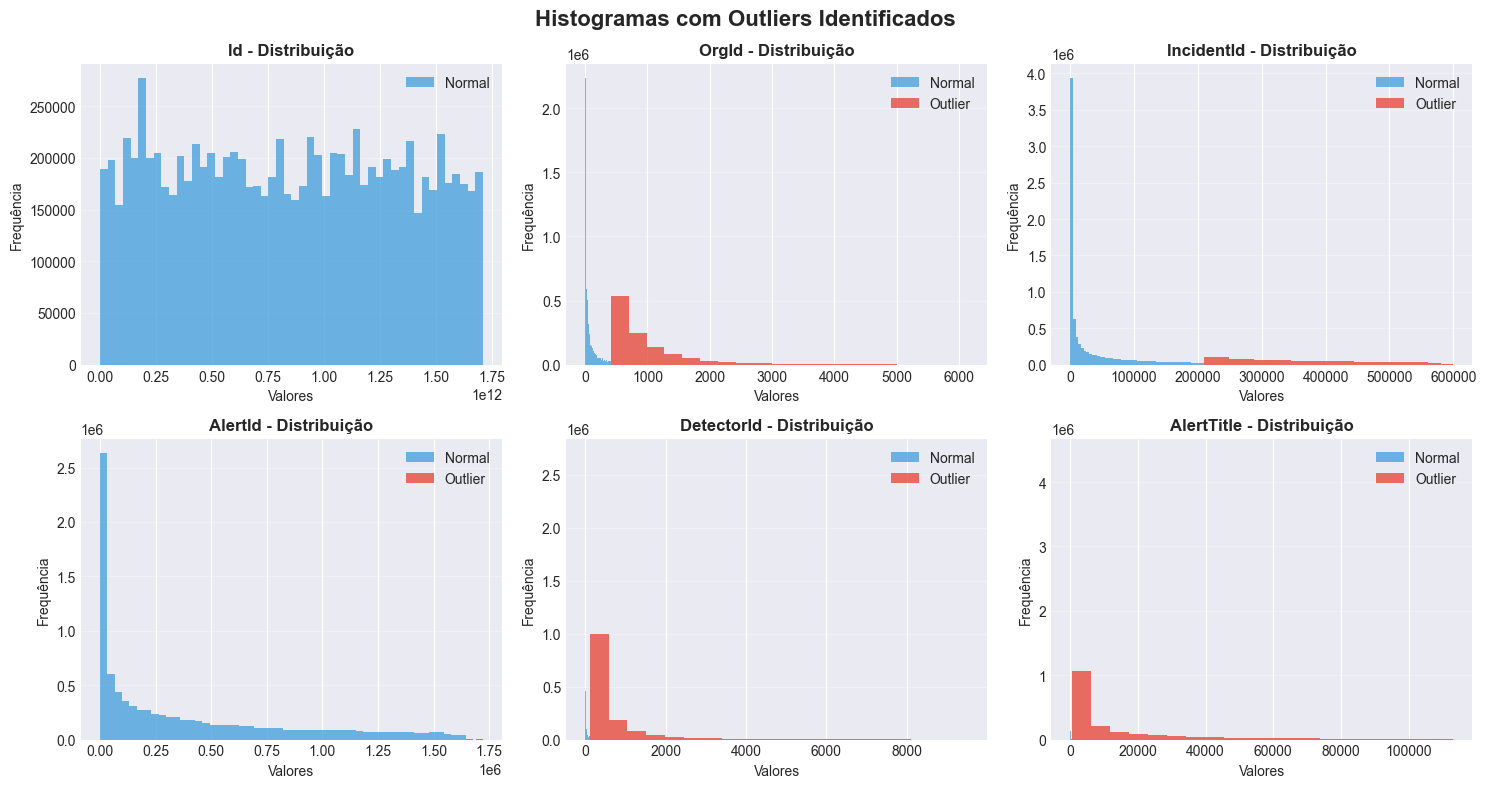

In [37]:
# Histogramas com outliers identificados
cols_hist = numerical_cols[:6]

if cols_hist:
    n_cols_hist = len(cols_hist)
    n_rows_hist = (n_cols_hist + 2) // 3
    
    fig, axes = plt.subplots(n_rows_hist, 3, figsize=(15, 4 * n_rows_hist))
    if n_rows_hist == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    for idx, col in enumerate(cols_hist):
        ax = axes[idx]
        
        outlier_mask = detect_outliers_iqr(df, col)
        
        # Plot normal values
        ax.hist(df.loc[~outlier_mask, col].dropna(), bins=50, color='#3498db', alpha=0.7, label='Normal')
        
        # Plot outliers
        if outlier_mask.sum() > 0:
            ax.hist(df.loc[outlier_mask, col].dropna(), bins=20, color='#e74c3c', alpha=0.8, label='Outlier')
        
        ax.set_xlabel('Valores')
        ax.set_ylabel('Frequência')
        ax.set_title(f'{col} - Distribuição', fontweight='bold')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
    
    # Ocultar axes extras
    for idx in range(len(cols_hist), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Histogramas com Outliers Identificados', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print('ℹ Nenhuma coluna numérica disponível para histogramas')

## 9. Análise de Duplicatas (Quality Check)

In [38]:
print('\n=== ANÁLISE DE DUPLICATAS ===\n')

duplicates_total = df.duplicated().sum()
duplicates_pct = (duplicates_total / len(df)) * 100
unique_records = len(df) - duplicates_total
unique_pct = (unique_records / len(df)) * 100

print(f'Total de registros: {len(df):,}')
print(f'Registros únicos: {unique_records:,} ({unique_pct:.2f}%)')
print(f'Registros duplicados: {duplicates_total:,} ({duplicates_pct:.2f}%)')

if 'IncidentId' in df.columns:
    dup_incident = df.duplicated(subset=['IncidentId'], keep=False).sum()
    print(f'\nDuplicatas por IncidentId: {dup_incident:,}')

if 'AlertId' in df.columns:
    dup_alert = df.duplicated(subset=['AlertId'], keep=False).sum()
    print(f'Duplicatas por AlertId: {dup_alert:,}')

print('\nℹ NOTA: Duplicatas devem ser preservadas na RAW (responsabilidade da SILVER)')


=== ANÁLISE DE DUPLICATAS ===

Total de registros: 9,516,837
Registros únicos: 9,494,278 (99.76%)
Registros duplicados: 22,559 (0.24%)

Duplicatas por IncidentId: 9,497,556
Duplicatas por AlertId: 9,486,788

ℹ NOTA: Duplicatas devem ser preservadas na RAW (responsabilidade da SILVER)


## 10. Distribuição de Categorias Principais

In [39]:
main_cats = ['Category', 'EntityType', 'EvidenceRole']
main_cats = [col for col in main_cats if col in df.columns]

print('\n=== DISTRIBUIÇÃO DE CATEGORIAS PRINCIPAIS ===\n')

for col in main_cats:
    print(f'\n{col}:')
    dist = df[col].value_counts()
    for val, count in dist.head(10).items():
        pct = (count / len(df)) * 100
        print(f'  • {val}: {count:,} ({pct:.2f}%)')
    if len(dist) > 10:
        print(f'  ... e mais {len(dist) - 10} valores')


=== DISTRIBUIÇÃO DE CATEGORIAS PRINCIPAIS ===


Category:
  • InitialAccess: 4,293,041 (45.11%)
  • Exfiltration: 1,577,965 (16.58%)
  • SuspiciousActivity: 1,003,933 (10.55%)
  • CommandAndControl: 826,691 (8.69%)
  • Impact: 750,885 (7.89%)
  • CredentialAccess: 300,518 (3.16%)
  • Execution: 267,594 (2.81%)
  • Malware: 144,081 (1.51%)
  • Discovery: 129,342 (1.36%)
  • Persistence: 72,682 (0.76%)
  ... e mais 10 valores

EntityType:
  • Ip: 2,181,194 (22.92%)
  • User: 1,932,416 (20.31%)
  • MailMessage: 1,173,154 (12.33%)
  • Machine: 699,208 (7.35%)
  • File: 688,402 (7.23%)
  • Url: 682,578 (7.17%)
  • CloudLogonRequest: 638,565 (6.71%)
  • Mailbox: 483,158 (5.08%)
  • Process: 345,732 (3.63%)
  • MailCluster: 224,684 (2.36%)
  ... e mais 23 valores

EvidenceRole:
  • Related: 5,208,644 (54.73%)
  • Impacted: 4,308,193 (45.27%)


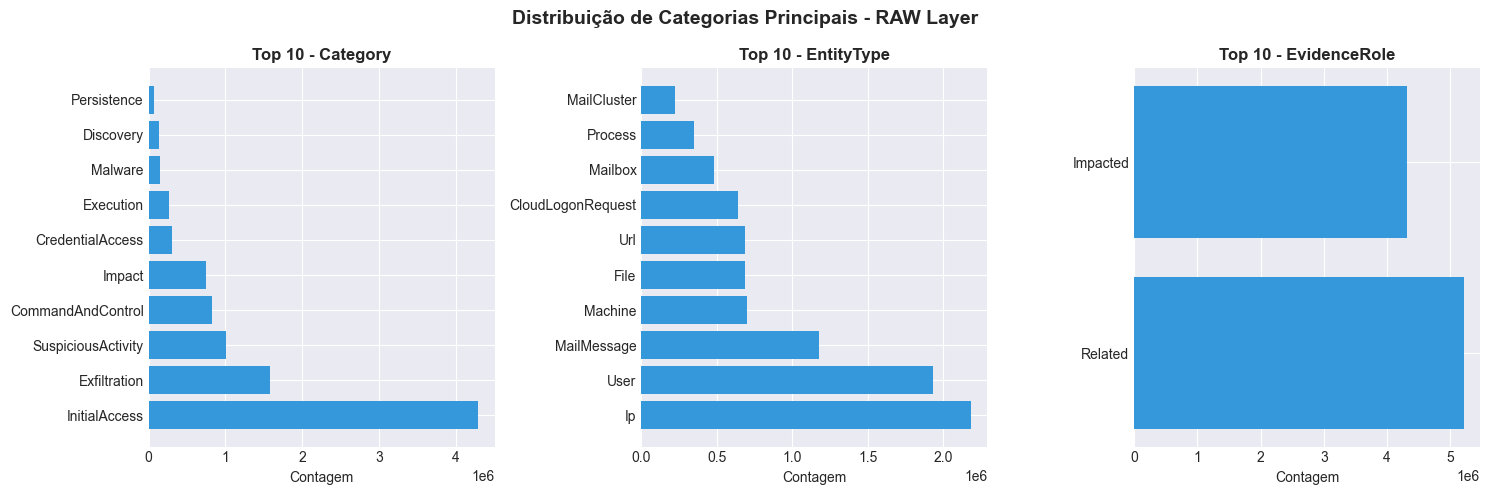

In [40]:
if main_cats:
    n_cats = len(main_cats)
    fig, axes = plt.subplots(1, n_cats, figsize=(5 * n_cats, 5))
    
    if n_cats == 1:
        axes = [axes]
    
    for idx, col in enumerate(main_cats):
        ax = axes[idx]
        top_values = df[col].value_counts().head(10)
        
        ax.barh(range(len(top_values)), top_values.values, color='#3498db')
        ax.set_yticks(range(len(top_values)))
        ax.set_yticklabels(top_values.index)
        ax.set_xlabel('Contagem')
        ax.set_title(f'Top 10 - {col}', fontweight='bold')
    
    plt.suptitle('Distribuição de Categorias Principais - RAW Layer', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print('ℹ Nenhuma categoria principal encontrada para visualização')

## 11. Resumo Executivo - Qualidade da Camada RAW

In [41]:
print(f'\n{"="*80}')
print('RESUMO EXECUTIVO - CAMADA RAW (BRONZE) - DATA VALIDATION & PROFILING')
print(f'{"="*80}\n')

print(' DIMENSÕES DO DATASET (RAW):')
print(f'Total de registros: {len(df):,}')
print(f'Total de colunas: {len(df.columns)}')
print(f'Memória total: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB')
print(f'Colunas categóricas: {len(categorical_cols)}')
print(f'Colunas numéricas: {len(numerical_cols)}')

print('\n QUALIDADE DOS DADOS:')
print(f'Registros duplicados: {duplicates_total:,} ({duplicates_pct:.2f}%)')
print(f'Colunas com valores ausentes: {(missing_data["Percentual"] > 0).sum()}')
print(f'Colunas SEM valores ausentes: {(missing_data["Percentual"] == 0).sum()}')
print(f'Colunas COM >95% ausentes: {(missing_data["Percentual"] > 95).sum()} (crítico)')

if 'IncidentGrade' in df.columns:
    print('\n VARIÁVEL TARGET:')
    for grade, count in df['IncidentGrade'].value_counts().items():
        pct = (count / len(df)) * 100
        print(f'  {grade}: {count:,} ({pct:.1f}%)')

print(f'\n OUTLIERS IDENTIFICADOS:')
print(f'Colunas numéricas: {len(numerical_cols)}')
if len(outliers_df) > 0:
    print(f'Colunas com outliers: {len(outliers_df)}')
    print(f'Total de registros com outliers: {outliers_df["Total Outliers"].sum():,}')
else:
    print('Nenhum outlier significativo detectado')

print(f'\n{"="*80}')
print(' ANÁLISE CONCLUÍDA')
print('\n PRÓXIMAS ETAPAS:')
print('   1. Dados RAW preservados intactos (sem transformações)')
print('   2. SILVER layer: Limpeza, deduplicação, tratamento de valores ausentes')
print('   3. GOLD layer: Feature engineering, modelagem, análise avançada')
print(f'{"="*80}\n')


RESUMO EXECUTIVO - CAMADA RAW (BRONZE) - DATA VALIDATION & PROFILING

 DIMENSÕES DO DATASET (RAW):
Total de registros: 9,516,837
Total de colunas: 45
Memória total: 7300.76 MB
Colunas categóricas: 13
Colunas numéricas: 31

 QUALIDADE DOS DADOS:
Registros duplicados: 22,559 (0.24%)
Colunas com valores ausentes: 11
Colunas SEM valores ausentes: 34
Colunas COM >95% ausentes: 7 (crítico)

 VARIÁVEL TARGET:
  BenignPositive: 4,110,817 (43.2%)
  TruePositive: 3,322,713 (34.9%)
  FalsePositive: 2,031,967 (21.4%)

⚠ OUTLIERS IDENTIFICADOS:
Colunas numéricas: 31
Colunas com outliers: 29
Total de registros com outliers: 23,043,716

 ANÁLISE CONCLUÍDA

 PRÓXIMAS ETAPAS:
   1. Dados RAW preservados intactos (sem transformações)
   2. SILVER layer: Limpeza, deduplicação, tratamento de valores ausentes
   3. GOLD layer: Feature engineering, modelagem, análise avançada



## 12. Metadados da Análise RAW

In [42]:
# Registrar metadados da análise RAW
raw_metadata = {
    'timestamp_analysis': datetime.now().isoformat(),
    'data_source': 'Kaggle - Microsoft Security Incident Prediction',
    'dataset_period': 'June 2024',
    'total_records': len(df),
    'total_columns': len(df.columns),
    'memory_mb': round(df.memory_usage(deep=True).sum() / 1024**2, 2),
    'checksum_md5': checksum,
    'categorical_columns': len(categorical_cols),
    'numerical_columns': len(numerical_cols),
    'duplicates_count': int(duplicates_total),
    'columns_with_missing': int((missing_data["Percentual"] > 0).sum()),
    'columns_with_missing_critical': int((missing_data["Percentual"] > 95).sum()),
    'outliers_detected': len(outliers_df)
}

# Salvar metadados no mesmo diretório do arquivo de dados
metadata_path = os.path.join(base_path, 'raw_metadata.json')

print('Salvando metadados...\n')
try:
    with open(metadata_path, 'w', encoding='utf-8') as f:
        json.dump(raw_metadata, f, indent=2, ensure_ascii=False)
    
    print(f' Metadados salvos em: {metadata_path}\n')
    print('Conteúdo:')
    print(json.dumps(raw_metadata, indent=2, ensure_ascii=False))
except Exception as e:
    print(f' Erro ao salvar metadados: {e}')
    print('\nMetadados gerados (não salvos):')
    print(json.dumps(raw_metadata, indent=2, ensure_ascii=False))

Salvando metadados...

✓ Metadados salvos em: C:\Users\fabio\OneDrive\Área de Trabalho\SBD2\data_layer\raw\raw_metadata.json

Conteúdo:
{
  "timestamp_analysis": "2025-11-07T00:49:13.790171",
  "data_source": "Kaggle - Microsoft Security Incident Prediction",
  "dataset_period": "June 2024",
  "total_records": 9516837,
  "total_columns": 45,
  "memory_mb": 7300.76,
  "checksum_md5": "115c2d188e80826d9fbdb9c8784afa22",
  "categorical_columns": 13,
  "numerical_columns": 31,
  "duplicates_count": 22559,
  "columns_with_missing": 11,
  "columns_with_missing_critical": 7,
  "outliers_detected": 29
}
